<a href="https://colab.research.google.com/github/leadeeerq/Projects/blob/main/221228_Projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
Analysis of the Top 50 rap songs over last years

---



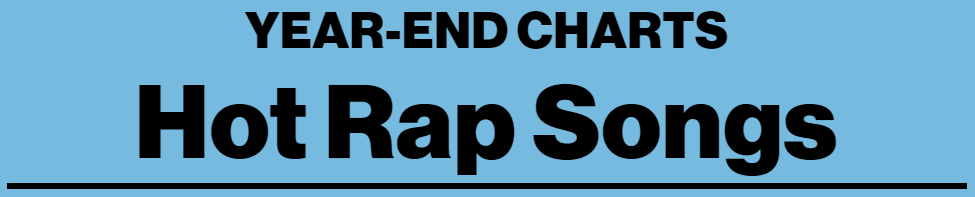

#Libraries

* Loading the necessary libraries.

In [444]:
from bs4 import BeautifulSoup as bs
import requests
import pickle
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob, Word
from collections import Counter
import pandas as pd
import re
import os
import plotly.express as px
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

#Scraping the billboard

* In this section, the web scraping process is presented. It is a method of extracting data from web pages that replace manual, repetitive typing or copying and pasting. In addition, the extracted data is often stored in a structured format.
* First, the ***requests*** library is used to send the HTTP request and, in return, get a Response Object with all the response data (web page content, encoding, etc.).
* Then, the ***BeautifulSoup*** library is used to pull data out of the HTML file (previously downloaded with the ***requests***.
* ***Prettify*** method allows the HTML code to be presented in a user-friendly presentation.


##Loading the webpage (2013)

In [ ]:
r = requests.get('https://www.billboard.com/charts/year-end/2013/hot-rap-songs/')

##Converting to the beautiful soup object

In [ ]:
soup = bs(r.content, 'html.parser')

##Printing out the HTML code

In [ ]:
contents = soup.prettify()
print(contents[:100])

<!DOCTYPE html>
<!--[if IE 6]>
<html id="ie6" lang="en-US">
<![endif]-->
<!--[if IE 7]>
<html id="ie


##Finding the tags

* The ***inspect element*** function was used to check the HTML code of the web page.
* The HTML tags were found, under which the searched information was hidden (***h3*** with titles of the songs, and particular ***div*** tag with artists names).
* Then, the dict of artists (keys) and their songs (values) was created.

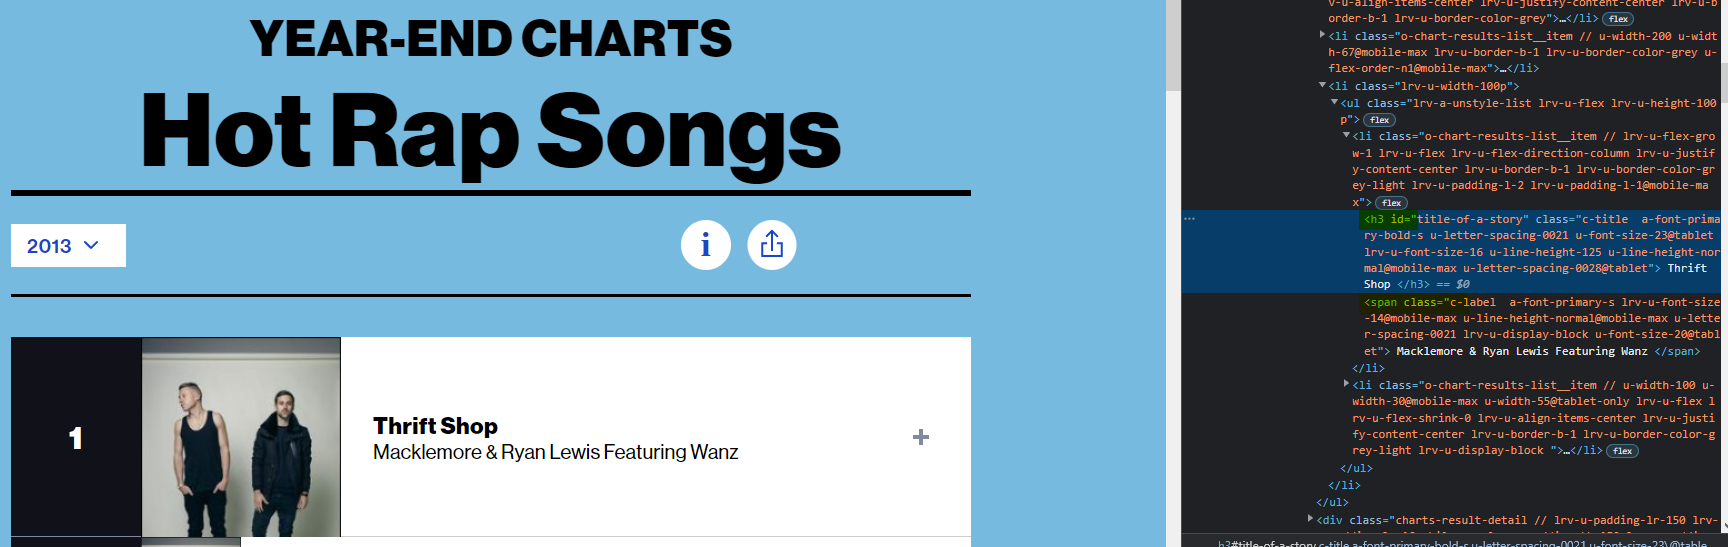

###Titles of the songs

In [ ]:
titles = []

for h3_tag in soup.find_all('h3')[:50]:
    titles.append(h3_tag.get_text(' ', strip = True))
    # print(h3_tag.get_text(' ', strip = True)) 

In [ ]:
titles[:3]

['Thrift Shop', "Can't Hold Us", 'Holy Grail']

###Artists

In [ ]:
artists = []

div_tag = soup.find('div', {'class': 'chart-results-list // u-padding-b-250'})
for li_tag in div_tag.find_all('li', {'class': 'lrv-u-width-100p'}):
  for span_tag in li_tag.find_all('span'):
    artists.append(span_tag.get_text(' ', strip = True))
    # print(span_tag.get_text(' ', strip = True))

In [ ]:
artists[:3]

['Macklemore & Ryan Lewis Featuring Wanz',
 'Macklemore & Ryan Lewis Featuring Ray Dalton',
 'Jay Z Featuring Justin Timberlake']

##Dict of artists and their songs

In [ ]:
songs_2013 = {}

for artist in artists:
  for song in titles:
    songs_2013[artist] = song
    # titles.remove(song)
    # break

In [ ]:
list(songs_2013.items())[:3]

[('Macklemore & Ryan Lewis Featuring Wanz', 'Pop That'),
 ('Macklemore & Ryan Lewis Featuring Ray Dalton', 'Pop That'),
 ('Jay Z Featuring Justin Timberlake', 'Pop That')]

#Scraping function

* All the steps described above were encapsulated in neat functions: ***scraping_to_dict*** and ***scraping_to_list***. 
* Function ***scraping_to_list*** was eventually used. The input was the URL address of the web page, and the function returned the dictionary of songs from the particular year (key was the year, and the value was the list with songs (artists + title))
* List of URLs was created to easily get URL for each year (from 2013 to 2022).
* The function for ***pickling*** the data was created.

##Definition of the function

In [ ]:
def scraping_to_dict(url):
  r = requests.get(url)
  soup = bs(r.content)

  titles = []
  artists = []
  songs_dict = {}

  for h3_tag in soup.find_all('h3')[:50]:
    titles.append(h3_tag.get_text(' ', strip = True))

  div_tag = soup.find('div', {'class': 'chart-results-list // u-padding-b-250'})
  for li_tag in div_tag.find_all('li', {'class': 'lrv-u-width-100p'}):
    for span_tag in li_tag.find_all('span'):
      artists.append(span_tag.get_text(' ', strip = True))

  for artist in artists:
    for song in titles:
      songs_dict[artist] = song
      titles.remove(song)
      break

  return songs_dict

In [ ]:
def scraping_to_list(url):
  r = requests.get(url)
  soup = bs(r.content)

  titles = []
  artists = []
  songs_list = []

  #Titles
  for h3_tag in soup.find_all('h3')[:50]:
    titles.append(h3_tag.get_text(' ', strip = True))

  #Artists
  div_tag = soup.find('div', {'class': 'chart-results-list // u-padding-b-250'})
  for li_tag in div_tag.find_all('li', {'class': 'lrv-u-width-100p'}):
    for span_tag in li_tag.find_all('span'):
      artists.append(span_tag.get_text(' ', strip = True))

  songs_list = [x + ' ' + y for x, y in zip(artists, titles)]

  return songs_list

##List of urls

In [ ]:
years = list(range(2013, 2023, 1))

base_url = 'https://www.billboard.com/charts/year-end/' #+year + end_url
end_url = '/hot-rap-songs/'

list_of_urls = []

for year in years:
  url = str(base_url + str(year) + end_url)
  list_of_urls.append(url)

In [ ]:
list_of_urls

['https://www.billboard.com/charts/year-end/2013/hot-rap-songs/',
 'https://www.billboard.com/charts/year-end/2014/hot-rap-songs/',
 'https://www.billboard.com/charts/year-end/2015/hot-rap-songs/',
 'https://www.billboard.com/charts/year-end/2016/hot-rap-songs/',
 'https://www.billboard.com/charts/year-end/2017/hot-rap-songs/',
 'https://www.billboard.com/charts/year-end/2018/hot-rap-songs/',
 'https://www.billboard.com/charts/year-end/2019/hot-rap-songs/',
 'https://www.billboard.com/charts/year-end/2020/hot-rap-songs/',
 'https://www.billboard.com/charts/year-end/2021/hot-rap-songs/',
 'https://www.billboard.com/charts/year-end/2022/hot-rap-songs/']

##Dict of songs of the last 9 years

In [ ]:
songs = {}

for year in years:
    songs[year] = scraping_to_list(list_of_urls[year - 2013])

In [ ]:
list(songs.items())[-1]

(2022,
 ['Jack Harlow First Class',
  'Future Featuring Drake & Tems Wait For U',
  'Latto Big Energy',
  'Kodak Black Super Gremlin',
  'Lil Nas X & Jack Harlow Industry Baby',
  'Drake Featuring 21 Savage Jimmy Cooks',
  'Doja Cat Vegas',
  'Lil Baby In A Minute',
  'Gunna & Future Featuring Young Thug Pushin P',
  'Megan Thee Stallion & Dua Lipa Sweetest Pie',
  'Nicki Minaj Super Freaky Girl',
  'Drake Featuring 21 Savage & Project Pat Knife Talk',
  'Drake Featuring Future & Young Thug Way 2 Sexy',
  'Lil Durk Featuring Morgan Wallen Broadway Girls',
  'Lil Durk Featuring Gunna What Happened To Virgil',
  'Future Puffin On Zootiez',
  'Drake Featuring Lil Baby Girls Want Girls',
  'JNR CHOI & Sam Tompkins To The Moon!',
  'Drake Sticky',
  'Nardo Wick Featuring G Herbo, Lil Durk & 21 Savage Who Want Smoke??',
  'Yung Gravy Betty (Get Money)',
  'Post Malone Featuring Roddy Ricch Cooped Up',
  "Hitkidd & GloRilla F.N.F. (Let's Go)",
  'DJ Khaled Featuring Drake & Lil Baby Staying A

##Saving a dict with the pickle library

In [330]:
def to_pickle(file, filename):
  base_url = '/content/drive/MyDrive/Projekty/PROJEKT/'
  with open (base_url+filename, 'wb') as handle:
    pickle.dump(file, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [ ]:
#Pickling the dict where key is the year and value is the list with songs
to_pickle(songs, 'songs.pickle')

In [ ]:
with open('/content/drive/MyDrive/Projekty/PROJEKT/songs.pickle', 'rb') as handle:
  songs = pickle.load(handle)

#Handling a specific year

* To process the data a different environment was needed, that could handle the ***selenium*** library. For this purpose, ***PyCharm*** was used.
* To reduce the size of the data, the dictionary was divided by year and saved to separate ***pickle*** files. These files were loaded into a script that automated the browser.
The script used a function called ***scraper(text)***, which would launch the Chrome browser, open a page with the given URL (function input), validate the data policy, and then look for a button on the page to expand the full lyrics of the song (items were searched by their xpath address). The URL (with the full lyrics of the song displayed) was then retrieved and processed using ***requests*** and ***beautiful soup*** libraries.
The song words were saved to the dictionary and then saved as a pickle file.

In [ ]:
#Show songs from year 2013
songs[2022]

['Jack Harlow First Class',
 'Future Featuring Drake & Tems Wait For U',
 'Latto Big Energy',
 'Kodak Black Super Gremlin',
 'Lil Nas X & Jack Harlow Industry Baby',
 'Drake Featuring 21 Savage Jimmy Cooks',
 'Doja Cat Vegas',
 'Lil Baby In A Minute',
 'Gunna & Future Featuring Young Thug Pushin P',
 'Megan Thee Stallion & Dua Lipa Sweetest Pie',
 'Nicki Minaj Super Freaky Girl',
 'Drake Featuring 21 Savage & Project Pat Knife Talk',
 'Drake Featuring Future & Young Thug Way 2 Sexy',
 'Lil Durk Featuring Morgan Wallen Broadway Girls',
 'Lil Durk Featuring Gunna What Happened To Virgil',
 'Future Puffin On Zootiez',
 'Drake Featuring Lil Baby Girls Want Girls',
 'JNR CHOI & Sam Tompkins To The Moon!',
 'Drake Sticky',
 'Nardo Wick Featuring G Herbo, Lil Durk & 21 Savage Who Want Smoke??',
 'Yung Gravy Betty (Get Money)',
 'Post Malone Featuring Roddy Ricch Cooped Up',
 "Hitkidd & GloRilla F.N.F. (Let's Go)",
 'DJ Khaled Featuring Drake & Lil Baby Staying Alive',
 'SleazyWorld Go Featuri

In [ ]:
print(len(songs[2022]))

50


In [ ]:
#Printing the first song in a dict
first_song = songs[2022][0]
first_song

'Jack Harlow First Class'

###Exporting songs list to a pickle file and processing it with PyCharm

In [ ]:
to_pickle(songs[2013], 'songs_2013.pickle')

In [ ]:
for year in years:
  to_pickle(songs[year], f'songs_{year}.pickle')

##PyCharm script

```
import os
import pickle
from bs4 import BeautifulSoup as bs
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

os.environ['PATH'] += r"C:/Users/Arek/PycharmProjects/PROJEKT_studia/"

with open('songs_2022.pickle', 'rb') as handle:
    dict_list_of_years = pickle.load(handle)

def scraper(text):
    text = text.replace('&', '')
    text = text.replace('Featuring', '')
    base_url = 'https://google.com/search?q='
    url = base_url + str(text) + ' lyrics'

    driver = webdriver.Chrome()
    driver.get(url)
    driver.implicitly_wait(3)
    driver.find_element_by_xpath('//*[@id="L2AGLb"]/div').click()
    driver.implicitly_wait(3)

    try:
        l = driver.find_element_by_xpath(
            '//*[@id="kp-wp-tab-overview"]/div[2]/div/div/div[2]/div/div/div/div/div/div/div[1]/div[2]/div/a')
        if l.size() == 0:
            pass
        else:
            l.click()
    except:
        pass

    # Wait for 5 seconds
    WebDriverWait(driver, 5).until(
        EC.invisibility_of_element(
            (
            By.XPATH, '//*[@id="kp-wp-tab-overview"]/div[2]/div/div/div[2]/div/div/div/div/div/div/div[1]/div[2]/div/a')
        )
    )
    current_url = driver.current_url
    # print(str(driver.current_url))

    # After "Pełny tekst" was clicked
    page_source = driver.page_source
    # print(page_source)

    soup = bs(page_source, features='lxml')
    div_tags = soup.find_all('div', {'class': 'xaAUmb'})
    lyrics = []
    for div_tag in div_tags:
        lyrics.append(div_tag.get_text(' ', strip=True))

    return lyrics

songs = {}

for i in range(len(dict_list_of_years)):
    try:
        songs[dict_list_of_years[i]] = scraper(dict_list_of_years[i])
    except:
        songs[dict_list_of_years[i]] = []

def to_pickle(file, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(file, handle, protocol=pickle.HIGHEST_PROTOCOL)

to_pickle(songs, 'PyCharm_songs_2022.pickle')
```



#Natural Language Processing

* This section shows how natural language was processed.
* First, the pickle file with lyrics was loaded.
* Then, values of the dictionary were aggregated (with the join function). In this data aggregate, the special characters were removed, as well as the polish phrase, that accidentally found its way into the text (it was included in the HTML tag).
* Spell correction function from the ***TextBlob*** library was applied to correct the lyrics.
* ***Sentiment*** of the aggregated lyrics were evaluated. ***Polarity*** lies between [-1, 1], -1 defines a negative sentiment and 1 defines a positive sentiment. ***Subjectivity*** lies between [0,1]. Subjectivity quantifies the amount of personal opinion and factual information contained in the text. The higher subjectivity means that the text contains personal opinions rather than factual information.
* ***Polarity*** is close to zero, which means that the text is neither negatively nor positively polarized. ***Subjectivity*** is close to 0,5 which indicates that the text contains about half each opinion and fact.
* Then, the words are ***tokenized***, which means that strings are divided into lists of substrings to find the words and punctuation in strings. Tokenized words were then tagged with parts of speech (PoS). ***Tagged words*** were then used to calculate the frequency of particular PoS.
* Corrected words were then changed to the ***lowercased*** and ***lemmatized*** (removing inflectional endings and returning the base or a dictionary form of a word, which is known as the lemma) with the ***NLTK*** library (with the ***TextBlob*** is possible as well).
* Nouns were extracted with the ***NLTK*** and ***TextBlob*** libraries to perform calculations of the most frequent word in the lyrics.
* Stopwords (such as "the", "a", "an", etc.) and extra spaces were removed.
* The ***word_processing*** function was created, which encapsulated all steps mentioned above. Its input was the pickled list and outputs were tagged words and nouns.
* Eventually in this section, the most frequent words were found. For this purpose function of counting words was created (count), which created the dictionary where the key was the word and the value was the number of instances in the text given as input. For example, in the year 2014, the most frequent word (noun) was "b*tch".
* The last paragraph of this section shows how the occurences of a given part of speech were counted. For validation of the method, the first song was checked.

##Loading the pickle created with PyCharm (dict of songs) to combine all lyrics in one list

In [ ]:
with open('/content/drive/MyDrive/Projekty/PROJEKT/PyCharm_songs/PyCharm_songs_2013.pickle', 'rb') as handle:
  songs_2013 = pickle.load(handle)

In [ ]:
#List of lists with lyrics
list_of_words_2013 = ''.join(str(list(songs_2013.values())))
list_of_words_2013

'[[\'Hey Macklemore? Can we go thrift shopping? What, what, what, what What, what, what, what What, what, what, what What, what, what, what What, what, what, what (bada, bada, bada doo da) What, what, what, what (bada, bada, bada doo da) What, what, what, what (bada, bada, bada doo da) What, what, what, what (bada, bada, bada doo da) oh oh (Bada, bada, bada doo da) (Bada, bada, bada doo da) ow I\\\'m gonna pop some tags Only got twenty dollars in my pocket I, I, I\\\'m hunting, looking for a come-up This is fucking awesome Nah walk up to the club like, what up, I got a big cock I\\\'m just pumped, just bought some shit from the thrift shop (oh) Ice on the fringe, it\\\'s so damn frosty The people like, "Damn! That\\\'s a cold ass honkey" Rollin\\\' in, hella deep, headin\\\' to the mezzanine Dressed in all pink, \\\'cept my gator shoes, those are green Draped in a leopard mink, girls standin\\\' next to me Probably shoulda washed this, smells like R. Kelly\\\'s sheets (Piss) But shit, 

##Removing special characters

In [ ]:
list_of_words_2013 = list_of_words_2013.replace("\\", "")
list_of_words_2013 = list_of_words_2013.replace("…", ".")
list_of_words_2013 = list_of_words_2013.replace("Coś się nie udało. Spróbuj jeszcze raz. Przetłumacz na: polski", " ")
list_of_words_2013

'[[\'Hey Macklemore? Can we go thrift shopping? What, what, what, what What, what, what, what What, what, what, what What, what, what, what What, what, what, what (bada, bada, bada doo da) What, what, what, what (bada, bada, bada doo da) What, what, what, what (bada, bada, bada doo da) What, what, what, what (bada, bada, bada doo da) oh oh (Bada, bada, bada doo da) (Bada, bada, bada doo da) ow I\'m gonna pop some tags Only got twenty dollars in my pocket I, I, I\'m hunting, looking for a come-up This is fucking awesome Nah walk up to the club like, what up, I got a big cock I\'m just pumped, just bought some shit from the thrift shop (oh) Ice on the fringe, it\'s so damn frosty The people like, "Damn! That\'s a cold ass honkey" Rollin\' in, hella deep, headin\' to the mezzanine Dressed in all pink, \'cept my gator shoes, those are green Draped in a leopard mink, girls standin\' next to me Probably shoulda washed this, smells like R. Kelly\'s sheets (Piss) But shit, it was ninety-nine c

##Spell correction (TextBlob)

In [ ]:
corrected_words_str = TextBlob(list_of_words_2013)
corrected_words_str = corrected_words_str.correct()

In [ ]:
corrected_words_str.sentiment

Sentiment(polarity=0.02233658876738605, subjectivity=0.48917429622217823)

In [ ]:
corrected_words_str = str(corrected_words_str)

##Tokenizing

In [ ]:
words = word_tokenize(corrected_words_str)

##Tagging with NLTK

In [ ]:
tagged_words = nltk.pos_tag(words)

##Uppercase to lowercase

In [ ]:
lowercased_words = corrected_words_str.lower()
lowercased_words = word_tokenize(lowercased_words)

##Lemmatization with the NLTK and TextBlob

In [ ]:
#NLTK
lemmatizer = WordNetLemmatizer()
lemmatized_words = " ". join([lemmatizer.lemmatize(word) for word in lowercased_words])
lemmatized_words = lemmatized_words.split() #Back to list

In [ ]:
#TextBlob
# lemmatized_words = TextBlob(corrected_words_str)
# lemmatized_words = " ". join([w.lemmatize() for w in lemmatized_words.words])
# lemmatized_words = lemmatized_words.split()

##Extracting nouns only with the NLTK and TextBlob

In [ ]:
#NLTK
#Function to test if the word is a noun
tagged_lem_words = nltk.pos_tag(lemmatized_words)
is_noun = lambda pos: pos[:2] in ['NN', 'NNS', 'NNP', 'NNPS']
nounsNLTK = [word for (word, pos) in tagged_lem_words if is_noun(pos)]

In [ ]:
nounsNLTK[100:110]

['man',
 'trash',
 'man',
 'granddad',
 'donation',
 'shirt',
 'right',
 'stanton',
 'goodwill',
 'bind']

In [ ]:
#TextBlob
tb = TextBlob(" ".join(lemmatized_words)) 
nounsTextBlob = [word for (word, pos) in tb.tags if pos in ['NN', 'NNS', 'NNP', 'NNPS']]

In [ ]:
nounsTextBlob[100:110]

['man',
 'trash',
 'man',
 'granddad',
 'donation',
 'shirt',
 'right',
 'stanton',
 'goodwill',
 'bind']

In [ ]:
nounsTextBlob == nounsNLTK

False

###Differences between NLTK and TextBlob tagging

In [ ]:
list(set(nounsNLTK) - set(nounsTextBlob))

['d.u.i.', 'r.i.p.', 'custom', 't.i.', 'pre-k']

##Removing stopwords

In [ ]:
stop_words = STOPWORDS
stop_words.update(["you'd", "i'd", "'ll", "'til", "'s", "ca n't", "n't", "'m", "'re", "y'all", "am", "im", "em"])
stripped_words = []
for word in lemmatized_words:
  if word not in stop_words:
    stripped_words.append(word)
stripped_words_str = " ".join(stripped_words)
stripped_words_str = stripped_words_str.translate({ord(i): None for i in '[],".\\()!?…'}).replace("'","")

##Removing extra spaces

In [ ]:
stripped_words_str = re.sub(' +', ' ', stripped_words_str)

---
##Words processing function
---

In [354]:
def words_processing(pickled_list):

  # if the pickled_list (of songs) is a dict and it has keys and values:
  if type(pickled_list) == dict:
    list_of_words = "".join(str(list(pickled_list.values())))
  else:
    list_of_words = "".join(str(list(pickled_list)))
  
  #Removing special characters and removing phrase with polish words (last paragraph)
  # "$", ":", ".", "''", "'", ")", "(", ",", "``", "`", "[", "]"
  list_of_words = list_of_words.replace("Coś się nie udało. Spróbuj jeszcze raz. Przetłumacz na: polski", "")
  list_of_words = list_of_words.translate({ord(i): None for i in ['[',']',',','"','.',')','(','!','?','…']})
  list_of_words = list_of_words.replace("\\", "")

  #Spell correction with TextBlob / optionally as it takes a lot of time to perform
  # corrected_words = TextBlob(list_of_words)
  # corrected_words = str(corrected_words.correct())

  #Tokenizing
  # words = word_tokenize(corrected_words)
  words = word_tokenize(list_of_words)

  #Tagging (with unprocessed words)
  tagged_words = nltk.pos_tag(words)

  #Exclude special characters from tagged_words (if not excluded before)
  # to_exclude = ['``',',','(',')',"'",'.',':',']','[',';','?', "''",]
  # tagged_words = [x for x in tagged_words if x[0] not in to_exclude]

  # ---------------------------------------
  # Performing steps to get number of words
  # ---------------------------------------

  #Changing all to lowercase
  lowercased_words = list_of_words.lower()
  lowercased_words = word_tokenize(lowercased_words)

  # Lemmatization with the TextBlob
  # lemmatized_words = TextBlob(lowercased_words)
  # lemmatized_words = " ". join([w.lemmatize() for w in lemmatized_words.words])
  # lemmatized_words = lemmatized_words.split() #Back to list

  #Lemmatization with the NLTK
  lemmatizer = WordNetLemmatizer()
  lemmatized_words = " ". join([lemmatizer.lemmatize(word) for word in lowercased_words])
  lemmatized_words = lemmatized_words.split() #Back to list

  #Extracting nouns only with NLTK
  tagged_lem_words = nltk.pos_tag(lemmatized_words)
  is_noun = lambda pos: pos[:2] in ['NN', 'NNS', 'NNP', 'NNPS']
  nouns = [word for (word, pos) in tagged_lem_words if is_noun(pos)]
  nouns_to_exclude = ['i', 'hol', 'la', 'j']
  nouns = [noun for noun in nouns if noun not in nouns_to_exclude]

  #Extracting nouns only with TextBlob
  tb = TextBlob(" ".join(lemmatized_words)) 
  nounsTextBlob = [word for (word, pos) in tb.tags if pos in ['NN', 'NNS', 'NNP', 'NNPS']]

  #Removing stopwords
  stop_words = STOPWORDS
  stop_words.update(["you'd", "i'd", "'ll", "'til", "'s", "ca n't", "n't", "'m", "'re", "y'all", "am", "im", "em"])
  stripped_words = []
  for word in lemmatized_words:
    if word not in stop_words:
      stripped_words.append(word)
  stripped_words_str = " ".join(stripped_words)
  stripped_words_str = stripped_words_str.translate({ord(i): None for i in '[],".\\()!?…'}).replace("'","")

  #Removing extra spaces
  stripped_words_str = re.sub(' +', ' ', stripped_words_str)

  return tagged_words, nouns

In [26]:
with open('/content/drive/MyDrive/Projekty/PROJEKT/PyCharm_songs/PyCharm_songs_2014.pickle', 'rb') as handle:
  songs_2014 = pickle.load(handle)

In [355]:
tagged_words, nouns = words_processing(songs_2014)

##Finding the most frequent word

In [356]:
def count(word):
  if not word:
    # dictionary = {np.NaN: np.NaN}
    return np.nan
  else:
  # Check if the '.' is the last character of the word, if so, ignore it
    if word[-1] == '.':
        word = word[0:len(word) - 1]
    # If the word already exists in dict, increment the value
    if word in dictionary:
        dictionary[word] += 1
    # If the word doesn't apprear in the dict, create the key and assign value of 1
    else:
        dictionary.update({word: 1})

In [357]:
dictionary = {}

for word in nouns:
    count(word)
 
for all_words in dictionary:
  if dictionary[all_words] >= 100:
    print ('Frequency of "', end = "")
    print(all_words, end = "")
    print('"', end = "")
    print (":", end = " ")
    print (dictionary[all_words])

Frequency of "bitch": 118
Frequency of "nigga": 118


In [359]:
(sorted(dictionary.items(), key=lambda item: item[1], reverse=True))[0][0]

'bitch'

In [361]:
dict(sorted(dictionary.items(), key=lambda item: item[1], reverse=True))

{'bitch': 118,
 'nigga': 118,
 'hitta': 92,
 'baby': 85,
 'shit': 78,
 'girl': 77,
 'man': 69,
 'money': 63,
 'night': 55,
 'yeah': 52,
 'time': 47,
 'way': 45,
 'fuck': 44,
 'day': 44,
 'work': 40,
 'trophy': 39,
 'hoe': 38,
 'stoner': 36,
 'something': 35,
 'name': 33,
 'love': 33,
 'foot': 32,
 'hookah': 32,
 'look': 28,
 'nothing': 28,
 "i'ma": 28,
 'bounce': 28,
 'get': 27,
 'pussy': 27,
 'club': 26,
 'game': 26,
 'people': 26,
 'life': 26,
 'hittas': 26,
 'hour': 26,
 'mediocre': 25,
 'boy': 24,
 'year': 24,
 'hand': 23,
 'song': 23,
 'thing': 19,
 'head': 19,
 'nobody': 18,
 'air': 18,
 'wa': 18,
 'side': 18,
 'city': 18,
 'fight': 18,
 'ma-man': 18,
 'let': 17,
 'one': 17,
 "i'mma": 17,
 'house': 17,
 'everybody': 17,
 'fire': 17,
 'gas': 15,
 'mama': 15,
 'lot': 15,
 'line': 14,
 'friend': 14,
 'car': 14,
 'ho': 14,
 'back': 14,
 'bound': 14,
 'fuckin': 13,
 'anaconda': 13,
 'uh': 13,
 'type': 13,
 'motherfuckin': 13,
 'rap': 13,
 'studio': 13,
 'left': 13,
 'watch': 13,
 'gue

* Most frequent words in 2014' lyrics are: bixxh, nixxa, baby, shxt, girl

##Counting verbs, nouns, and other parts of speech with python's NLTK

```
Parts of speech:
# 1.	CC	Coordinating conjunction
# 2.	CD	Cardinal number
# 3.	DT	Determiner
# 4.	EX	Existential there
# 5.	FW	Foreign word
# 6.	IN	Preposition or subordinating conjunction
# 7.	JJ	Adjective
# 8.	JJR	Adjective, comparative
# 9.	JJS	Adjective, superlative
# 10.	LS	List item marker
# 11.	MD	Modal
# 12.	NN	Noun, singular or mass
# 13.	NNS	Noun, plural
# 14.	NNP	Proper noun, singular
# 15.	NNPS	Proper noun, plural
# 16.	PDT	Predeterminer
# 17.	POS	Possessive ending
# 18.	PRP	Personal pronoun
# 19.	PRP$	Possessive pronoun
# 20.	RB	Adverb
# 21.	RBR	Adverb, comparative
# 22.	RBS	Adverb, superlative
# 23.	RP	Particle
# 24.	SYM	Symbol
# 25.	TO	to
# 26.	UH	Interjection
# 27.	VB	Verb, base form
# 28.	VBD	Verb, past tense
# 29.	VBG	Verb, gerund or present participle
# 30.	VBN	Verb, past participle
# 31.	VBP	Verb, non-3rd person singular present
# 32.	VBZ	Verb, 3rd person singular present
# 33.	WDT	Wh-determiner
# 34.	WP	Wh-pronoun
# 35.	WP$	Possessive wh-pronoun
```

In [362]:
#Checking tags of the first 2 song lines
tagged_words[0:21]

[('First', 'NNP'),
 ('things', 'NNS'),
 ('first', 'RB'),
 ('I', 'PRP'),
 ("'m", 'VBP'),
 ('the', 'DT'),
 ('realest', 'NN'),
 ('realest', 'NN'),
 ('Drop', 'NN'),
 ('this', 'DT'),
 ('and', 'CC'),
 ('let', 'VB'),
 ('the', 'DT'),
 ('whole', 'JJ'),
 ('world', 'NN'),
 ('feel', 'VB'),
 ('it', 'PRP'),
 ('let', 'VB'),
 ("'em", 'PRP'),
 ('feel', 'VB'),
 ('it', 'PRP')]

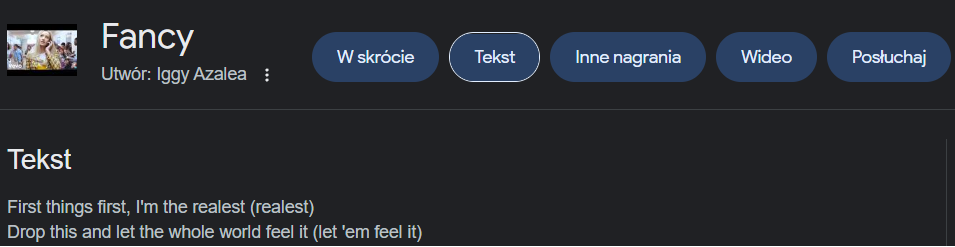

In [363]:
#Counting the parts of speech
counts = Counter(tag for word,tag in tagged_words)
counts

Counter({'NNP': 2348,
         'NNS': 738,
         'RB': 1853,
         'PRP': 4314,
         'VBP': 2370,
         'DT': 2452,
         'NN': 4293,
         'CC': 656,
         'VB': 1645,
         'JJ': 1672,
         'IN': 2905,
         'MD': 328,
         'RP': 377,
         "''": 456,
         'VBZ': 520,
         'PRP$': 707,
         'POS': 358,
         'PDT': 35,
         'VBD': 868,
         'WP': 209,
         'WRB': 211,
         'TO': 523,
         'VBN': 279,
         'EX': 18,
         'VBG': 420,
         'WDT': 103,
         'JJR': 80,
         'CD': 228,
         'RBR': 14,
         ':': 6,
         'NNPS': 16,
         'JJS': 27,
         'FW': 109,
         'UH': 4,
         'WP$': 2})

In [448]:
#Normalizing the values(occurencies of the PoS) 
total = sum(counts.values())
dict((word, float(count)/total) for word,count in counts.items())

{'NNP': 0.07539172874389931,
 'NNS': 0.0236963781145646,
 'RB': 0.05949781659388646,
 'PRP': 0.13851785255586951,
 'VBP': 0.07609812483945544,
 'DT': 0.07873105574107372,
 'NN': 0.13784356537374776,
 'CC': 0.021063447212946312,
 'VB': 0.05281916259953763,
 'JJ': 0.053686103262265604,
 'IN': 0.09327639352684305,
 'MD': 0.010531723606473156,
 'RP': 0.012105060364757256,
 "''": 0.014641664526072438,
 'VBZ': 0.016696634985872077,
 'PRP$': 0.02270100179809915,
 'POS': 0.011494991009504239,
 'PDT': 0.0011238119702029284,
 'VBD': 0.02787053686103262,
 'WP': 0.0067107629077832005,
 'WRB': 0.006774980734651939,
 'TO': 0.016792961726175185,
 'VBN': 0.008958386848189058,
 'EX': 0.0005779604418186488,
 'VBG': 0.01348574364243514,
 'WDT': 0.0033072180837400464,
 'JJR': 0.0025687130747495505,
 'CD': 0.007320832263036219,
 'RBR': 0.0004495247880811713,
 ':': 0.0001926534806062163,
 'NNPS': 0.0005137426149499101,
 'JJS': 0.0008669406627279733,
 'FW': 0.0034998715643462623,
 'UH': 0.0001284356537374775

#Creating the dataset

* In this section the dataset was created. It was designed to present 35 types of parts of speech, the number of unique words, the total number of words, and the year from which the song originated.
* A function for processing a list of strings was created. It helped to validate the correctness of the PoS tagging. This was compared with the tagging result from the website ***parts-of-speech.info***.
* Then, a simple data frame was created.
* A function ***extract_unique*** for counting the unique words was created. It was validated with the example string and, for lyrics, it was cross-checked with the results from the webpage ***planetcalc.com/3205***
* A function ***create_df*** for creating the dataset was created

Artist | Song | Parts of speech (35 cols) | Unique words | Total words | Most frequent words (top 1) | Year

##Function for counting parts of speech




In [365]:
TEXT = ['It is a final project for postgraduate studies.','In it, I deal with natural language processing. It is a great (and challenging) task']

In [366]:
parts_of_speech = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH',
                     'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$']

In [367]:
len(parts_of_speech)

35

In [368]:
#Function for processing simple example
def example_processing(text):
  text = "".join(str(text))
  text = text.replace("'", "")
  text = text.translate({ord(i): None for i in ['[',']',',','"','.',')','(','!','?','…']})
  words = word_tokenize(text)
  tagged_words = nltk.pos_tag(words)
  return tagged_words, words

In [369]:
example_tagged_words, words = example_processing(TEXT)

In [370]:
example_tagged_words

[('It', 'PRP'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('final', 'JJ'),
 ('project', 'NN'),
 ('for', 'IN'),
 ('postgraduate', 'JJ'),
 ('studies', 'NNS'),
 ('In', 'IN'),
 ('it', 'PRP'),
 ('I', 'PRP'),
 ('deal', 'VBP'),
 ('with', 'IN'),
 ('natural', 'JJ'),
 ('language', 'NN'),
 ('processing', 'NN'),
 ('It', 'PRP'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('great', 'JJ'),
 ('and', 'CC'),
 ('challenging', 'JJ'),
 ('task', 'NN')]

In [371]:
def counting_pos(tagged_words):
  counts_dict = {}
  for pos in parts_of_speech:
    values = Counter(tag for word, tag in tagged_words if tag == pos)
    for count in values.values():
      counts_dict[pos] = count
  return counts_dict

In [372]:
counting_pos(example_tagged_words)

{'CC': 1,
 'DT': 2,
 'IN': 3,
 'JJ': 5,
 'NN': 4,
 'NNS': 1,
 'PRP': 4,
 'VBP': 1,
 'VBZ': 2}

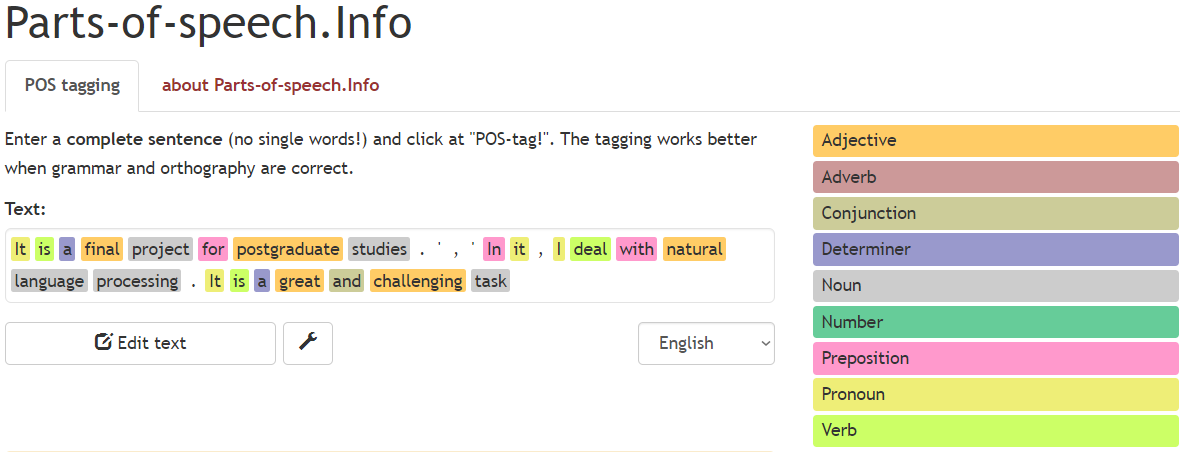

Source: Parts-of-speech.info
* CC: 1
* DT: 2
* IN: 3
* JJ: 5
* NN: 4
* NNS: 1
* PRP: 4
* VBP: 1
* VBZ: 2


In [373]:
dfx = pd.DataFrame(counting_pos(example_processing(TEXT)[0]), index=[0])

In [374]:
dfx

,CC,DT,IN,JJ,NN,NNS,PRP,VBP,VBZ
0,1,2,3,5,4,1,4,1,2


##Function for extracting unique words from the lyrics

In [375]:
def extract_unique(text):
  _, words = example_processing(text)
  words = [word.lower() for word in words]
  unique_words = set(words)
  return len(unique_words), len(words), unique_words

In [376]:
unique_words, total_words, _ = extract_unique(TEXT)
unique_words, total_words

(19, 23)

In [377]:
extract_unique('I am Arkadiusz and I am a professional data scientist. Or I try to be professional.')

(12,
 16,
 {'a',
  'am',
  'and',
  'arkadiusz',
  'be',
  'data',
  'i',
  'or',
  'professional',
  'scientist',
  'to',
  'try'})

##Function for creating the df

In [379]:
parts_of_speech = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH',
                     'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$']

df_cols = ['Year', 'Artist', 'Song'] + parts_of_speech

def create_df(pickled_list, year):
  df1 = pd.DataFrame()
  df2 = pd.DataFrame()
  df = pd.DataFrame()
  
  for item in pickled_list.items():
    row = pd.DataFrame(counting_pos(words_processing(item[1])[0]), index = [item[0]])
    df1 = df1.append(row)
    dictionary = {}
    nouns = words_processing(item[1])[1]
    if not nouns:
      rowx = pd.DataFrame({'most_freq_noun':np.nan}, index = [item[0]])
    else:
      for word in nouns:
        if word[-1] == '.':
          word = word[0:len(word) - 1]
        if word in dictionary:
          dictionary[word] += 1
        else:
          dictionary.update({word: 1})
      mfn = sorted(dictionary.items(), key=lambda kv: kv[1], reverse=True)[0][0]
        
    row_ = pd.DataFrame({'unique_words': extract_unique(item[1])[0], 'total_words': extract_unique(item[1])[1], 'most_freq_noun': mfn, 'year': year}, index = [item[0]])
    df2 = df2.append(row_)
  df = df1.join(df2)
  
  return df

In [380]:
df_test = create_df(songs_2014, 2014)

In [381]:
df_test.head()

,CC,DT,EX,IN,JJ,MD,NN,NNS,NNP,PDT,...,RBR,NNPS,FW,JJS,UH,WP$,unique_words,total_words,most_freq_noun,year
Iggy Azalea Featuring Charli XCX Fancy,7.0,50.0,1.0,55.0,27.0,7.0,62.0,9.0,51.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,210,490,name,2014
Pitbull Featuring Ke$ha Timber,6.0,35.0,NaN,20.0,10.0,17.0,68.0,3.0,15.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,111,354,night,2014
Eminem Featuring Rihanna The Monster,27.0,50.0,NaN,75.0,61.0,9.0,101.0,21.0,33.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,276,676,head,2014
Iggy Azalea Featuring Rita Ora Black Widow,18.0,27.0,1.0,60.0,25.0,12.0,39.0,3.0,15.0,1.0,...,3.0,NaN,NaN,NaN,NaN,NaN,197,553,widow,2014
Nicki Minaj Anaconda,10.0,30.0,NaN,73.0,52.0,4.0,94.0,20.0,58.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,182,608,look,2014


* Source: planetcalc.com/3205
* Unique words in Iggy Azalea Featuring Charli XCX - Fancy
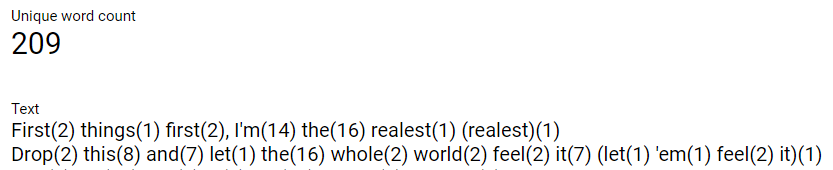

In [382]:
df_test.iloc[0]['unique_words']

210

#All datasets combined

* The creation of a single data frame was successful, so in this section, the data frames for each year were created and linked together.
* Pickle files were stored in the folder. It was automatically searched for files, which were then loaded into a dictionary and used as inputs to functions.
* Data frames were then packed into the list (***frames***) and concatenated with the ***pd.concat*** function.
* The result was the data frame of the size of 500 rows and 36 columns. It was pickled in the end.

##Access to the directory

In [383]:
directory = '/content/drive/MyDrive/Projekty/PROJEKT/PyCharm_songs'
years = list(range(2013, 2023, 1))
d = {}

#Iterate over files in the directory
for filename in os.listdir(directory):
  f = os.path.join(directory, filename)
  #Checking if it is a file
  if os.path.isfile(f):
    with open(f, 'rb') as handle:
      year = re.findall('[0-9]+', filename)[0]
      d['lyrics_{0}'.format(year)] = pickle.load(handle)

In [384]:
d.keys()

dict_keys(['lyrics_2013', 'lyrics_2014', 'lyrics_2015', 'lyrics_2016', 'lyrics_2017', 'lyrics_2018', 'lyrics_2019', 'lyrics_2020', 'lyrics_2021', 'lyrics_2022'])

In [385]:
d['lyrics_2014'] == d['lyrics_2013']

False

In [386]:
d['lyrics_2014'] == songs_2014

True

##Processing lyrics to get most frequent nouns

In [429]:
_, nouns_2013 = words_processing(d['lyrics_2013'])
_, nouns_2014 = words_processing(d['lyrics_2014'])
_, nouns_2015 = words_processing(d['lyrics_2015'])
_, nouns_2016 = words_processing(d['lyrics_2016'])
_, nouns_2017 = words_processing(d['lyrics_2017'])
_, nouns_2018 = words_processing(d['lyrics_2018'])
_, nouns_2019 = words_processing(d['lyrics_2019'])
_, nouns_2020 = words_processing(d['lyrics_2020'])
_, nouns_2021 = words_processing(d['lyrics_2021'])
_, nouns_2022 = words_processing(d['lyrics_2022'])

##Create dataframes

In [388]:
df_2013 = create_df(d['lyrics_2013'], 2013)
df_2014 = df_test
df_2015 = create_df(d['lyrics_2015'], 2015)
df_2016 = create_df(d['lyrics_2016'], 2016)
df_2017 = create_df(d['lyrics_2017'], 2017)
df_2018 = create_df(d['lyrics_2018'], 2018)
df_2019 = create_df(d['lyrics_2019'], 2019)
df_2020 = create_df(d['lyrics_2020'], 2020)
df_2021 = create_df(d['lyrics_2021'], 2021)
df_2022 = create_df(d['lyrics_2022'], 2022)

In [389]:
frames = [df_2013, df_2014, df_2015, df_2016, df_2017, df_2018, df_2019, df_2020, df_2021, df_2022]
df_orig = pd.concat(frames)

##Final DataFrame

In [390]:
df_orig

,CC,CD,DT,FW,IN,JJ,MD,NN,NNS,NNP,...,PDT,WP$,JJS,RBR,NNPS,RBS,unique_words,total_words,most_freq_noun,year
Macklemore & Ryan Lewis Featuring Wanz Thrift Shop,12.0,3.0,70.0,1.0,62.0,51.0,8.0,133.0,31.0,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,284,708,bada,2013
Macklemore & Ryan Lewis Featuring Ray Dalton Can't Hold Us,21.0,2.0,60.0,NaN,74.0,33.0,29.0,96.0,21.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,244,720,hey,2013
Jay Z Featuring Justin Timberlake Holy Grail,21.0,19.0,48.0,NaN,68.0,44.0,10.0,105.0,13.0,39.0,...,3.0,1.0,NaN,NaN,NaN,NaN,253,722,day,2013
Drake Started From The Bottom,3.0,1.0,60.0,NaN,55.0,26.0,2.0,88.0,5.0,14.0,...,1.0,NaN,NaN,NaN,NaN,NaN,143,474,bottom,2013
Pitbull Featuring Christina Aguilera Feel This Moment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,bottom,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Juice WRLD Already Dead,3.0,7.0,36.0,NaN,54.0,39.0,13.0,112.0,26.0,24.0,...,NaN,NaN,NaN,3.0,1.0,NaN,136,562,yeah,2022
Baby Keem & Kendrick Lamar Family Ties,20.0,18.0,91.0,NaN,88.0,48.0,6.0,137.0,37.0,65.0,...,1.0,NaN,2.0,NaN,NaN,1.0,384,870,bitch,2022
Rod Wave Alone,7.0,2.0,25.0,NaN,28.0,18.0,2.0,35.0,13.0,26.0,...,5.0,NaN,NaN,1.0,NaN,NaN,162,334,yeah,2022
Megan Thee Stallion Plan B,15.0,NaN,42.0,2.0,51.0,39.0,13.0,99.0,11.0,22.0,...,NaN,NaN,NaN,NaN,NaN,2.0,216,625,bitch,2022


In [391]:
to_pickle(df_orig, 'df.pickle')

#Data analysis

* This section is showing the analysis of the prepared data.

In [392]:
with open('/content/drive/MyDrive/Projekty/PROJEKT/df.pickle', 'rb') as handle:
  df_orig = pickle.load(handle)

In [393]:
df = df_orig.copy()

In [453]:
df.describe(include = 'all')

,CC,CD,DT,FW,IN,JJ,MD,NN,NNS,NNP,...,WP$,JJS,RBR,NNPS,RBS,unique_words,total_words,most_freq_noun,year,ratio
count,416.000000,347.000000,420.000000,71.000000,420.000000,421.000000,398.000000,421.000000,418.000000,421.000000,...,3.0,128.000000,94.000000,64.000000,18.000000,421.000000,421.000000,421,421.000000,421.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,223,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yeah,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41,NaN,NaN
mean,12.108173,5.844380,47.119048,3.591549,54.564286,35.099762,7.497487,89.465558,16.485646,48.071259,...,1.0,2.101562,1.797872,1.500000,1.277778,210.194774,600.344418,NaN,2017.546318,0.355146
std,7.542351,6.737351,20.728156,12.099088,22.661632,17.092452,6.226517,37.572303,10.543096,25.999444,...,0.0,2.261767,1.904041,1.038925,0.460889,63.760527,173.256492,NaN,2.915618,0.065979
min,1.000000,1.000000,6.000000,1.000000,3.000000,3.000000,1.000000,7.000000,1.000000,6.000000,...,1.0,1.000000,1.000000,1.000000,1.000000,53.000000,223.000000,NaN,2013.000000,0.088333
25%,7.000000,2.000000,32.000000,1.000000,38.000000,24.000000,3.000000,61.000000,9.000000,31.000000,...,1.0,1.000000,1.000000,1.000000,1.000000,166.000000,481.000000,NaN,2015.000000,0.313321
50%,11.000000,4.000000,44.000000,1.000000,52.000000,33.000000,6.000000,84.000000,14.000000,43.000000,...,1.0,1.000000,1.000000,1.000000,1.000000,206.000000,584.000000,NaN,2018.000000,0.351145
75%,15.250000,7.000000,60.000000,2.000000,67.000000,44.000000,9.750000,112.000000,21.000000,58.000000,...,1.0,2.000000,2.000000,1.250000,1.750000,247.000000,708.000000,NaN,2020.000000,0.401776


In [395]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, Macklemore & Ryan Lewis Featuring Wanz Thrift Shop to Armani White Billie Eilish.
Data columns (total 37 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CC              472 non-null    float64
 1   CD              395 non-null    float64
 2   DT              476 non-null    float64
 3   FW              81 non-null     float64
 4   IN              476 non-null    float64
 5   JJ              477 non-null    float64
 6   MD              449 non-null    float64
 7   NN              477 non-null    float64
 8   NNS             474 non-null    float64
 9   NNP             477 non-null    float64
 10  POS             447 non-null    float64
 11  PRP             477 non-null    float64
 12  PRP$            475 non-null    float64
 13  RB              475 non-null    float64
 14  RP              458 non-null    float64
 15  TO              472 non-null    float64
 16  VB          

##Drop rows with songs with no lyrics downloaded (0 total words)

In [396]:
df = df.drop(df[df['total_words'] == 0].index)
df

,CC,CD,DT,FW,IN,JJ,MD,NN,NNS,NNP,...,PDT,WP$,JJS,RBR,NNPS,RBS,unique_words,total_words,most_freq_noun,year
Macklemore & Ryan Lewis Featuring Wanz Thrift Shop,12.0,3.0,70.0,1.0,62.0,51.0,8.0,133.0,31.0,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,284,708,bada,2013
Macklemore & Ryan Lewis Featuring Ray Dalton Can't Hold Us,21.0,2.0,60.0,NaN,74.0,33.0,29.0,96.0,21.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,244,720,hey,2013
Jay Z Featuring Justin Timberlake Holy Grail,21.0,19.0,48.0,NaN,68.0,44.0,10.0,105.0,13.0,39.0,...,3.0,1.0,NaN,NaN,NaN,NaN,253,722,day,2013
Drake Started From The Bottom,3.0,1.0,60.0,NaN,55.0,26.0,2.0,88.0,5.0,14.0,...,1.0,NaN,NaN,NaN,NaN,NaN,143,474,bottom,2013
"A$AP Rocky Featuring Drake, 2 Chainz & Kendrick Lamar F**kin Problems",21.0,1.0,60.0,NaN,50.0,46.0,8.0,132.0,33.0,40.0,...,1.0,NaN,1.0,NaN,NaN,NaN,245,756,problem,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Juice WRLD Already Dead,3.0,7.0,36.0,NaN,54.0,39.0,13.0,112.0,26.0,24.0,...,NaN,NaN,NaN,3.0,1.0,NaN,136,562,yeah,2022
Baby Keem & Kendrick Lamar Family Ties,20.0,18.0,91.0,NaN,88.0,48.0,6.0,137.0,37.0,65.0,...,1.0,NaN,2.0,NaN,NaN,1.0,384,870,bitch,2022
Rod Wave Alone,7.0,2.0,25.0,NaN,28.0,18.0,2.0,35.0,13.0,26.0,...,5.0,NaN,NaN,1.0,NaN,NaN,162,334,yeah,2022
Megan Thee Stallion Plan B,15.0,NaN,42.0,2.0,51.0,39.0,13.0,99.0,11.0,22.0,...,NaN,NaN,NaN,NaN,NaN,2.0,216,625,bitch,2022


##Count and drop duplicated indices

In [397]:
df.duplicated()

Macklemore & Ryan Lewis Featuring Wanz Thrift Shop                       False
Macklemore & Ryan Lewis Featuring Ray Dalton Can't Hold Us               False
Jay Z Featuring Justin Timberlake Holy Grail                             False
Drake Started From The Bottom                                            False
A$AP Rocky Featuring Drake, 2 Chainz & Kendrick Lamar F**kin Problems    False
                                                                         ...  
Juice WRLD Already Dead                                                  False
Baby Keem & Kendrick Lamar Family Ties                                   False
Rod Wave Alone                                                           False
Megan Thee Stallion Plan B                                               False
Armani White Billie Eilish.                                              False
Length: 477, dtype: bool

In [398]:
df.groupby(df.index.tolist(),as_index=False).size()

,index,size
0,"2 Chainz Featuring Ty Dolla $ign, Trey Songz &...",1
1,21 Savage & Metro Boomin Featuring Drake Mr. R...,1
2,21 Savage & Metro Boomin No Heart,1
3,21 Savage A Lot,1
4,21 Savage Bank Account,2
...,...,...
416,"Young Thug, J. Cole & Travis Scott The London",1
417,YoungBoy Never Broke Again Outside Today,1
418,Yung Gravy Betty (Get Money),1
419,Zay Hilfigerrr & Zayion McCall Juju On That Be...,2


In [399]:
df = df[~df.index.duplicated(keep='first')]

In [400]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 421 entries, Macklemore & Ryan Lewis Featuring Wanz Thrift Shop to Armani White Billie Eilish.
Data columns (total 37 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CC              416 non-null    float64
 1   CD              347 non-null    float64
 2   DT              420 non-null    float64
 3   FW              71 non-null     float64
 4   IN              420 non-null    float64
 5   JJ              421 non-null    float64
 6   MD              398 non-null    float64
 7   NN              421 non-null    float64
 8   NNS             418 non-null    float64
 9   NNP             421 non-null    float64
 10  POS             395 non-null    float64
 11  PRP             421 non-null    float64
 12  PRP$            419 non-null    float64
 13  RB              419 non-null    float64
 14  RP              404 non-null    float64
 15  TO              416 non-null    float64
 16  VB          

##Histogram of the PoS

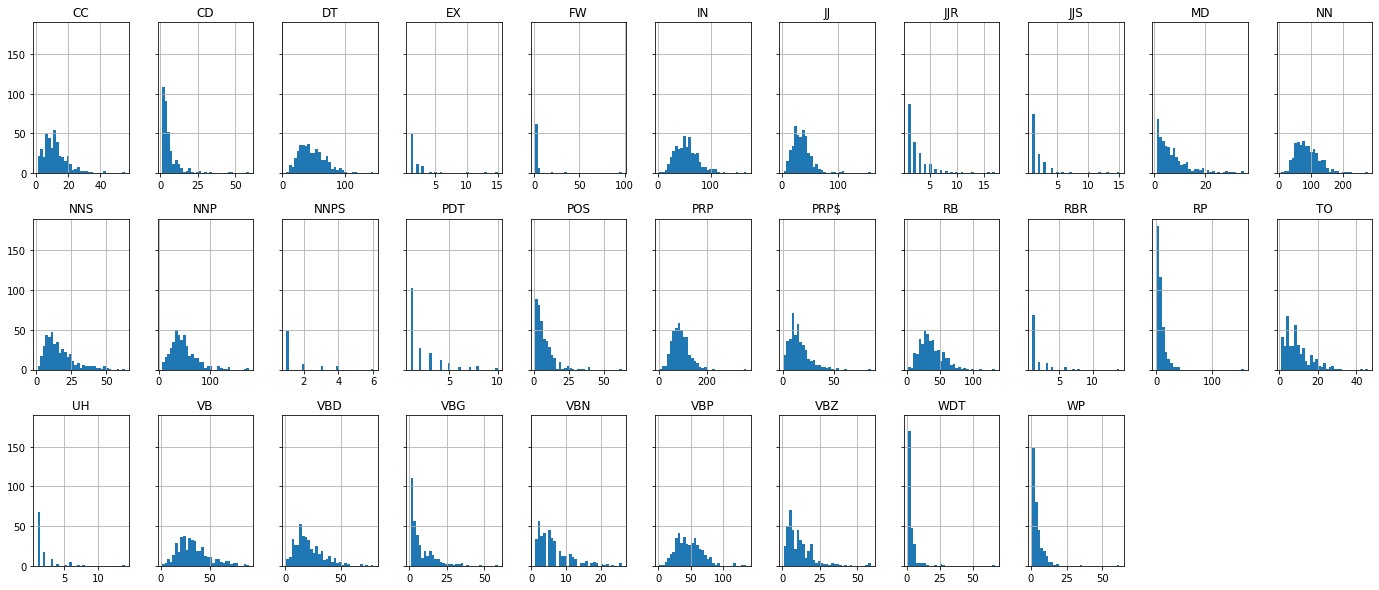

In [401]:
parts_of_speech = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RP', 'TO', 'UH',
                     'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP']

hist = df[parts_of_speech].hist(bins=33, figsize = (24,10), layout = (3, 11), sharey = True)

##Histogram of unique and total number of words

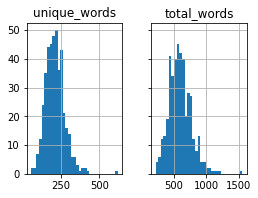

In [402]:
hist = df[['unique_words','total_words']].hist(bins=33, figsize = (24,10), layout = (3, 11), sharey = True)

##Find the song with the highest and lowest number of unique words

In [403]:
print(df['unique_words'].idxmax(),'with', df['unique_words'].loc[df['unique_words'].idxmax()], 'words.')

Eminem Rap God with 625 words.


In [404]:
print(df['unique_words'].idxmin(),'with', df['unique_words'].loc[df['unique_words'].idxmin()], 'words.')

Silento Watch Me with 53 words.


##Most frequent words in lyrics

In [405]:
df['most_freq_noun'].value_counts()

yeah      41
bitch     33
nigga     14
way       12
life       8
          ..
ballin     1
rico       1
panda      1
hola       1
dah        1
Name: most_freq_noun, Length: 223, dtype: int64

##Unique to total words ratio


In [410]:
df['ratio'] = df['unique_words']/df['total_words']

<ipython-input-410-c21eefe1916a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ratio'] = df['unique_words']/df['total_words']


In [411]:
df.head()

,CC,CD,DT,FW,IN,JJ,MD,NN,NNS,NNP,...,WP$,JJS,RBR,NNPS,RBS,unique_words,total_words,most_freq_noun,year,ratio
Macklemore & Ryan Lewis Featuring Wanz Thrift Shop,12.0,3.0,70.0,1.0,62.0,51.0,8.0,133.0,31.0,32.0,...,NaN,NaN,NaN,NaN,NaN,284,708,bada,2013,0.401130
Macklemore & Ryan Lewis Featuring Ray Dalton Can't Hold Us,21.0,2.0,60.0,NaN,74.0,33.0,29.0,96.0,21.0,66.0,...,NaN,NaN,NaN,NaN,NaN,244,720,hey,2013,0.338889
Jay Z Featuring Justin Timberlake Holy Grail,21.0,19.0,48.0,NaN,68.0,44.0,10.0,105.0,13.0,39.0,...,1.0,NaN,NaN,NaN,NaN,253,722,day,2013,0.350416
Drake Started From The Bottom,3.0,1.0,60.0,NaN,55.0,26.0,2.0,88.0,5.0,14.0,...,NaN,NaN,NaN,NaN,NaN,143,474,bottom,2013,0.301688
"A$AP Rocky Featuring Drake, 2 Chainz & Kendrick Lamar F**kin Problems",21.0,1.0,60.0,NaN,50.0,46.0,8.0,132.0,33.0,40.0,...,NaN,1.0,NaN,NaN,NaN,245,756,problem,2013,0.324074


In [414]:
print(df['ratio'].idxmax(),'with', round(df['ratio'].loc[df['ratio'].idxmax()],2), 'ratio of unique words.')

T-Wayne Nasty Freestyle with 0.61 ratio of unique words.


In [416]:
print(df['ratio'].idxmin(),'with', round(df['ratio'].loc[df['ratio'].idxmin()],2), 'ratio of unique words.')

Silento Watch Me with 0.09 ratio of unique words.


##Unique words in "most_freq_noun" column

In [419]:
print(df['most_freq_noun'].unique(), len(df['most_freq_noun'].unique()))

['bada' 'hey' 'day' 'bottom' 'problem' 'bitch' 'night' 'love' 'girl'
 '강남스타일' 'cry' 'drank' 'everybody' 'dollar' 'justice' 'way' 'bugatti'
 'yeah' 'clique' 'gas' 'mother' 'foot' 'worry' 'gold' 'friend' 'dance'
 'tapout' 'head' 'heart' 'nose' 'tom' 'end' 'ball' 'rip' 'chop' 'rap'
 'hitta' 'battle' 'nigga' 'everything' 'thun' 'pop' 'name' 'widow' 'look'
 'something' 'singing' 'mediocre' 'cadillac' 'studio' 'pill' 'fire' 'zone'
 'song' 'money' 'work' 'nothing' 'stoner' 'bounce' 'matter' 'language'
 'cliché' 'hookah' 'guess' 'bound' 'trophy' 'survival' 'hour' 'watch'
 'city' 'baby' 'bop' 'thing' 'time' 'home' 'homie' 'ooh' 'thinkin' 'eye'
 'quan' 'downtown' 'lot' 'mo' 'man' 'let' 'wa' 'feelin' 'jumpman' 'body'
 'woe' "i'mma" 'plan' 'ballin' 'rico' 'god' 'panda' 'life' 'ayy' 'hola'
 'ringin' 'pain' 'dm' 'style' 'woah' 'timmy' 'mind' 'key' 'part' 'morning'
 'aye' 'break' 'thang' 'ring' 'khalifa' 'whoa' 'promise' 'hype' 'nobody'
 'percocets' 'spy' 'face' 'bag' 'lil' 'rockstar' 'ice' 'dna' 'lo

#Word clouds

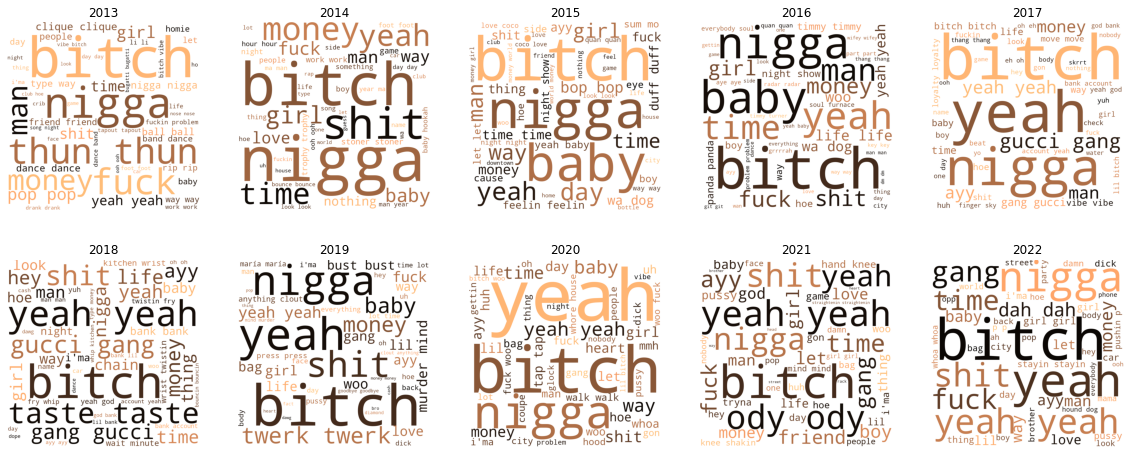

In [443]:
to_cloud = [nouns_2013, nouns_2014, nouns_2015, nouns_2016, nouns_2017, nouns_2018, nouns_2019, nouns_2020, nouns_2021, nouns_2022]

fig = plt.figure(figsize=(20, 8))
rows = 2
columns = 5

for idx, cloud in enumerate(to_cloud):
  words = ' '.join(str(x) for x in cloud)
  mask = np.array(Image.open('/content/drive/MyDrive/Projekty/PROJEKT/Cloud.png')) #Creating a mask for the cloud

  stop_words = STOPWORDS
  stop_words.update(['hol', 'hitta'])

  wc = WordCloud(max_words=50,
                relative_scaling=0.5,
                mask=mask,
                background_color='white',
                stopwords=stop_words,
                margin=2,
                random_state=7,
                contour_width=2,
                contour_color='brown',
                colormap='copper').generate(words)
  
  colors = wc.to_array() #Converting the wordcloud to the array to show it

  fig.add_subplot(rows, columns, idx+1)
  plt.imshow(colors)
  plt.axis('off')
  plt.title(idx+2013)

#Next steps

* Downloading song lyrics verse by verse,
* Train a machine learning algorithm to create its own lyrics with the most common words



#Changelog

Zmiany 07.12.2022
* rozdzielenie funkcji scraping na scraping_to_dict (obsolete) i scraping_to_list, aby nie zagnieżdżać słownika: rok: artrysta: tytuł -> rok: artysta tytuł - OK
* scraping z google - działa, ale należy rozszerzyć wynik (kliknięcie "pełny tekst") - NOK
* policzona częstotliwość występowania słów w dict_2013 - OK
---
- naprawić stop_words (głównie apostrofy) - OK
- pełny tekst piosenek z google - OK
- do chmury słów wybrać tylko rzeczowniki i ew. czasowniki! - OK

Zmiany 08.12.2022
* Import selenium do kliknięcia na przycisk "Full lyrics" (jeśl występuje) - funkcja w PyCharmie, wpisana w postaci tekstu do colaba' - OK

Zmiany 11.12.2022
* Scrapowanie googla przez PyCharm - dict zapisany jako pickle, który należy zaimporować do colaba - OK

Zmiany 15.12.2022
* ZAMIENIĆ liczbę wystąpień słów na liczbę unikalnych słów - OK

Zmiany 16.12.2022
* Dodana kolumna z liczbą słów i liczbą unikalnych słów - OK
* ZAMIENIĆ funkcję na zliczanie części mowy (nie działa poprawnie), nie podawać listy słów, a pełne zdania - tokenizacja przed usunięciem znaków specjalnych - OK

Zmiany 19.12.2022
* Usunąć na początku '' (zliczany w tagowanych słowach)
* Kamień milowy - zwalidowana funkcja zliczania PoS - OK
* Kamień milowy - zwalidowana funkcja liczenia słów - OK

Zmiany 27.12
* Dodane opisy rozdziałów - OK
* Wprowadzone poprawki do kodu - OK
* Dodane most_freq_noun do data frame - OK